In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd
import torch.distributions as dist

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

from rebar import g, g_tilde, g_lmbda, H, sigma, log_likelihood_bern

sns.set_style("whitegrid")

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<Axes: ylabel='Count'>

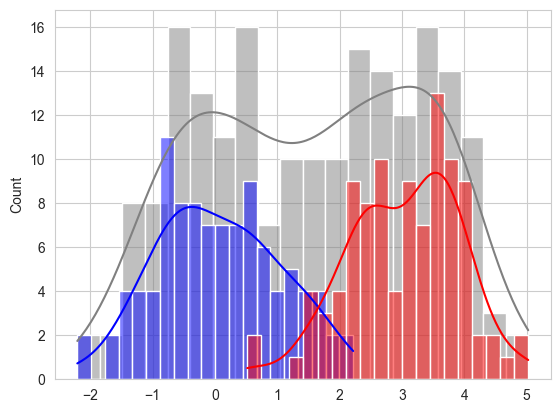

In [3]:
Xs = torch.concatenate([
    torch.randn(100),
    torch.randn(100) + 3,
]).reshape(-1, 1)

sns.histplot(Xs[:, 0], bins=20, kde=True, color='gray', alpha=0.5)
sns.histplot(Xs[:100, 0], bins=20, kde=True, color='blue', alpha=0.5)
sns.histplot(Xs[100:, 0], bins=20, kde=True, color='red', alpha=0.5)

In [4]:
def create_objective():
    def objective(b, mu0, mu1, sigma0, sigma1):
        # Use 1D normal distributions instead of multivariate normal
        dist_0 = dist.Normal(mu0, sigma0)
        dist_1 = dist.Normal(mu1, sigma1)
        
        # Calculate the probabilities for each data point (Xs)
        p0 = torch.exp(dist_0.log_prob(Xs))  # P(Xs | D0)
        p1 = torch.exp(dist_1.log_prob(Xs))  # P(Xs | D1)
        theta = p1 / (p0 + p1)
        
        # Likelihood is a mixture of the two components
        likelihood = (theta ** b) + ((1 - theta) ** (1 - b))
        
        # Log-likelihood for all points in Xs
        log_likelihood = torch.sum(torch.log(likelihood))
        
        return log_likelihood
    
    return objective

f = create_objective()

In [5]:
class GMM(nn.Module):
    def __init__(self):
        super(GMM, self).__init__()
        self.mu0 = nn.Parameter(torch.randn(()))
        self.mu1 = nn.Parameter(torch.randn(()))
        self.sigma0 = nn.Parameter(torch.abs(torch.randn(())))
        self.sigma1 = nn.Parameter(torch.abs(torch.randn(())))
    
    def forward(self, x):
        # Assume equal priors
        P_D1 = 0.5
        P_D2 = 0.5
        
        dist_0 = dist.Normal(self.mu0, self.sigma0)
        dist_1 = dist.Normal(self.mu1, self.sigma1)
        
        P_x_given_D1 = torch.exp(dist_0.log_prob(x))
        P_x_given_D2 = torch.exp(dist_1.log_prob(x))
        
        denominator = P_x_given_D1 * P_D1 + P_x_given_D2 * P_D2
        
        P_D1_given_x = (P_x_given_D1 * P_D1) / denominator
        
        return P_D1_given_x

In [9]:
max_iter = 5000

losses = []
variances = []
grad_estimates_list = []
grad_estimates_history = []
z_tilde_history = []
rebar_before_grad_history = []
log_prob_history = []
z_history = []
etas = []
lmbdas = []
thetas = []
rebar_before_grads = []
objectives = []

n_variance_samples = 1024

lmbda = torch.tensor([0.1], requires_grad=True)
eta = torch.tensor([-0.1], requires_grad=True)

theta_model = GMM()

opt = torch.optim.Adam(theta_model.parameters(), lr=0.01, betas=(0.9, 0.99999))
opt2 = torch.optim.Adam([eta, lmbda], lr=0.1, betas=(0.9, 0.99999))

for i in tqdm(range(max_iter)):
    opt.zero_grad()

    thetas_pred = theta_model.forward(Xs)

    # Gradient estimation
    thetas = thetas_pred.detach()
    thetas.requires_grad = True

    loss = 0
    u, v = torch.rand(2, thetas.shape[0], 1)

    z_lmbda = g_lmbda(u, thetas, lmbda)
    b = H(z_lmbda).detach()
    z_tilde = g_tilde(v, b, thetas)

    obj = f(b, theta_model.mu0, theta_model.mu1, theta_model.sigma0, theta_model.sigma1)

    objectives.append(torch.mean(obj).item()) 

    obj_temp_detach = f(sigma(z_tilde.detach(), lmbda), theta_model.mu0, theta_model.mu1, theta_model.sigma0, theta_model.sigma1)
    obj_temp = f(sigma(z_tilde.detach(), lmbda), theta_model.mu0, theta_model.mu1, theta_model.sigma0, theta_model.sigma1)
    first_term = (obj - eta * obj_temp_detach) * log_likelihood_bern(b, thetas)
    second_term = eta * obj_temp
    thrid_term = -eta * obj_temp
    loss += first_term + second_term + thrid_term

    grad_estimate = autograd.grad(torch.mean(loss), thetas, create_graph=True)[0]
    eta.grad, lmbda.grad = autograd.grad(torch.mean(grad_estimate ** 2), (eta, lmbda))

    autograd.backward(thetas_pred, grad_estimate.detach())
    opt.step()

    lmbda.data = torch.clamp(lmbda.data, 0.001)


 46%|████▌     | 2290/5000 [00:01<00:02, 1175.24it/s]


ValueError: Expected parameter scale (Parameter of shape ()) of distribution Normal(loc: Parameter containing:
tensor(-1.3035, requires_grad=True), scale: Parameter containing:
tensor(-0.0011, requires_grad=True)) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
Parameter containing:
tensor(-0.0011, requires_grad=True)

<Axes: ylabel='Count'>

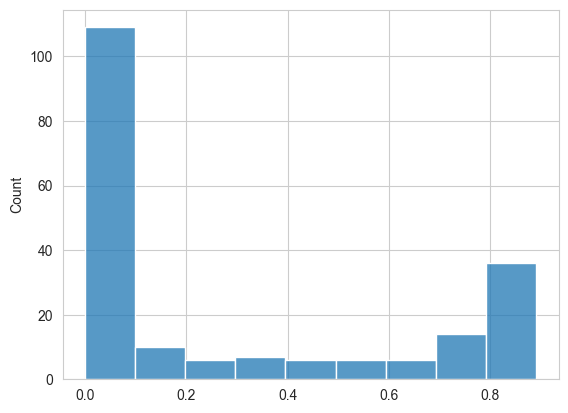

In [16]:
sns.histplot(theta_pred.detach().numpy().reshape((-1,)))